Copyright (c) 2017-2018 [Serpent-Tools developer team](https://github.com/CORE-GATECH-GROUP/serpent-tools/graphs/contributors), GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Results Reader

##  Basic operations

This notebook demonstrates the capabilities of the serpentTools to read Serpent results files. SERPENT [1] produces a result file (i.e. `_res.m`), containing general results (e.g. `k-eff`), metadata (e.g. `title`) and homogenized cross-sections. The homogenized cross-section sets are printed in the results file for all the requested universes. The ResultsReader is capable of reading this file, and storing the data inside univ objects. Each such object has methods and attributes that should ease the analyses.

In [1]:
import numpy as np
import serpentTools
from serpentTools.settings import rc
rc['serpentVersion'] = '2.1.30'

In [2]:
%time
resFile = 'InnerAssembly_res.m'
res = serpentTools.read(resFile)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


# Metadata (`metadata`)

`metadata` is a collective data that describes the problem.
The following data is included: titles, data paths, and other descriptive data exist on the reader 

In [3]:
print(res.metadata['version'])  # Serpent version used for the execution
print(res.metadata['decayDataFilePath'])  # Directory path for data libraries
print(res.metadata['inputFileName'])  # Directory path for data libraries

Serpent 2.1.30
/nv/hp22/dkotlyar6/data/Codes/DATA/endfb7/sss_endfb7.dec
InnerAssembly


Obtain all the variables in the metadata via `.keys()`

In [4]:
res.metadata.keys()

dict_keys(['version', 'compileDate', 'debug', 'title', 'confidentialData', 'inputFileName', 'workingDirectory', 'hostname', 'cpuType', 'cpuMhz', 'startDate', 'completeDate', 'pop', 'cycles', 'skip', 'batchInterval', 'srcNormMode', 'seed', 'ufsMode', 'ufsOrder', 'neutronTransportMode', 'photonTransportMode', 'groupConstantGeneration', 'b1Calculation', 'b1BurnupCorrection', 'implicitReactionRates', 'optimizationMode', 'reconstructMicroxs', 'reconstructMacroxs', 'doubleIndexing', 'mgMajorantMode', 'spectrumCollapse', 'mpiTasks', 'ompThreads', 'mpiReproducibility', 'ompReproducibility', 'ompHistoryProfile', 'shareBufArray', 'shareRes2Array', 'xsDataFilePath', 'decayDataFilePath', 'sfyDataFilePath', 'nfyDataFilePath', 'braDataFilePath'])

In [5]:
# Grep the value of a certain key, e.g. simulation start date
res.metadata['startDate']

'Sat Apr 28 06:09:54 2018'

In [6]:
# statistics used for the execution (histories, inactive and active cycles)
print(res.metadata['pop'], res.metadata['skip']  , res.metadata['cycles'])

5000 10 50


In [7]:
# Obtain the version defined in the settings
print('User defined version: {}'.format(rc['serpentVersion']))
# Obtain the version actually used in the execution
print('Used version: {}'.format(res.metadata['version']))

User defined version: 2.1.30
Used version: Serpent 2.1.30


# Results Data (`resdata`)

Results are stored as a function of time/burnup/index and include integral parameters of the system.
Results, such as `k-eff`, total `flux`, execution times are included in `.resdata`. Some results include values and uncertainities (e.g. criticality) and some just the values (e.g. CPU resources). 

In [8]:
# All the variables can be obtained by using 'resdata.keys()'
AllVariables = res.resdata.keys() # contains all the variable as a dict_keys
# The example below shows only the first five variables in the resdata dictionary
list(AllVariables)[0:5]

['minMacroxs', 'dtThresh', 'stFrac', 'dtFrac', 'dtEff']

In [9]:
# Time-dependent variables, such as k-eff, are stored in 'resdata'
print(res.resdata['absKeff'])  # Values (1st col.) + std (2nd col.) 

[[1.29160e+00 9.00000e-04]
 [1.29500e+00 9.30000e-04]
 [1.29172e+00 9.10000e-04]
 [1.29172e+00 7.80000e-04]
 [1.29312e+00 6.80000e-04]
 [1.29140e+00 7.80000e-04]]


In [10]:
# Obtain only the values for 'absKeff'
res.resdata['absKeff'][:,0]

array([1.2916 , 1.295  , 1.29172, 1.29172, 1.29312, 1.2914 ])

In [11]:
# Obtain only the uncertainties for 'absKeff'
res.resdata['absKeff'][:,1]

array([0.0009 , 0.00093, 0.00091, 0.00078, 0.00068, 0.00078])

In [12]:
# Burnup data is not written by default, a burnup mode is defined within the input file
# Extract burnup related quantities
print(res.resdata['burnup']) # burnup intervals (MWd/kg) 
print(res.resdata['burnDays']) # time points (days)

[[0.       0.      ]
 [0.1      0.100001]
 [1.       1.00001 ]
 [2.       2.00001 ]
 [3.       3.00003 ]
 [4.       4.00004 ]]
[[ 0.     ]
 [ 1.20048]
 [12.0048 ]
 [24.0096 ]
 [36.0144 ]
 [48.0192 ]]


In [13]:
# Some variables are stored with no uncertainties
print(res.resdata['totCpuTime']) # total CPU time,  

[[10.814 ]
 [20.3573]
 [30.0783]
 [39.4965]
 [48.919 ]
 [58.6448]]


## Plotting Results Data (`resdata`)

Basic 1-D plotting capabilities are not yet avaialble in the parser. 

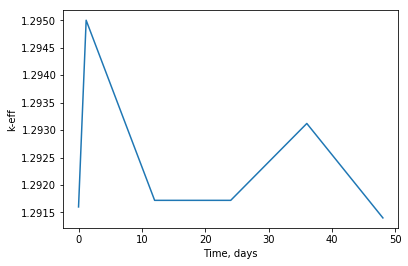

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
xdata = res.resdata['burnDays'][:] # obtain the time in (days)
ydata = res.resdata['absKeff'][:,0] # obtain the k-eff (values only)
plt.plot(xdata, ydata)
plt.xlabel('Time, days')
plt.ylabel('k-eff');

# Universe Data (`universes`)

Universe data is stored for each state point, i.e. `('univ',burnup, burnupIdx, time)`

`'univ'`: universe ID (e.g., `'0'`), `burnup`: in MWd/kg, `burnupIdx`: step index, `time`: in days.  
Results, such as infinite cross-sections, b1-leakage corrected cross-sections, kinetic parameters, are included in `.universes`. All the results include values and uncertainties. 

In [15]:
# The different states are obtained by:
res.universes.keys()
# The next cell presents the various unique states ('univ',burnup, burnupIdx, time)

dict_keys([('3101', 0.0, 1, 0.0), ('3102', 0.0, 1, 0.0), ('0', 0.0, 1, 0.0), ('3101', 0.1, 2, 1.20048), ('3102', 0.1, 2, 1.20048), ('0', 0.1, 2, 1.20048), ('3101', 1.0, 3, 12.0048), ('3102', 1.0, 3, 12.0048), ('0', 1.0, 3, 12.0048), ('3101', 2.0, 4, 24.0096), ('3102', 2.0, 4, 24.0096), ('0', 2.0, 4, 24.0096), ('3101', 3.0, 5, 36.0144), ('3102', 3.0, 5, 36.0144), ('0', 3.0, 5, 36.0144), ('3101', 4.0, 6, 48.0192), ('3102', 4.0, 6, 48.0192), ('0', 4.0, 6, 48.0192)])

In [16]:
# Let's use the following unique state
print(res.universes[('3102', 0.0, 1, 0.0)])

<HomogUniv 3102: burnup: 0.000 MWd/kgu, step: 1, 0.000 days>


Each state contains the same data fields, which can be obatined by using the following attributes on the `HomogUniv` objects: 

`.infExp`: infinite values, e.g. `INF_ABS`, 

`.infUnc`: infinite uncertainties, 

`.b1Exp`:  b1 (leakage corrected) values, e.g. `B1_ABS`,  

`.b1Exp`:  b1 (leakage corrected) uncertainties, 

`.gc`: variables that are not included in 'inf' or 'b1', e.g. `BETA`

`.gcUnc`: group uncertainties

`.groups`: macro energy group structure, MeV

`.microGroups`: micro energy group structure, MeV

## Get Universe Data (`.getUniv`)

A method to obtain the data for a specific universe and time of interest. 
In order to obtain the data, the user needs to pass the `universe id` and the `time point`:

`.getUniv(univ, burnup, index, time)`

`univ` must be a string
`burnup` is a float or int with the units MWd/kgU
`time` is a float or int with the units Days
`index` is a positive integer (i.e. 1, 2, ...)

The method requires to insert the universe and burnup or time or index (only one of these is actually used to retrieve the data). 
If more than one time parameter is given, the hierarchy of search is:
index (highest priority), burnup, time (lowest priority)

In [17]:
# Examples to use various time entries
univ3101 = res.getUniv('3101', index=4) # obtain the results for universe=3101 and index=4 
univ3102 = res.getUniv('3102', burnup=0.1) # obtain the results for universe=3102 and index=0.1 MWd/kgU
univ0 = res.getUniv('0', timeDays=24.0096) # obtain the results for universe=0 and index=24.0096 days

In [18]:
# The full states are printed below
print(univ3101)
print(univ3102)
print(univ0)

<HomogUniv 3101: burnup: 2.000 MWd/kgu, step: 4, 24.010 days>
<HomogUniv 3102: burnup: 0.100 MWd/kgu, step: 2, 1.200 days>
<HomogUniv 0: burnup: 2.000 MWd/kgu, step: 4, 24.010 days>


In [19]:
# obtain the results for universe=0 and index=1 (burnup and timeDays are inserted but not used)
univ0 = res.getUniv('0', burnup=0.0, index=1, timeDays=0.0)  
print(univ0)

<HomogUniv 0: burnup: 0.000 MWd/kgu, step: 1, 0.000 days>


In [20]:
# The parser reads all the variables by default
# Each field is a dictionary, with variables as keys and corresponding values.
univ0.infExp.keys() # obtain all the variables stored in 'infExp' field

dict_keys(['infMicroFlx', 'infKinf', 'infFlx', 'infFissFlx', 'infTot', 'infCapt', 'infAbs', 'infFiss', 'infNsf', 'infNubar', 'infKappa', 'infInvv', 'infScatt0', 'infScatt1', 'infScatt2', 'infScatt3', 'infScatt4', 'infScatt5', 'infScatt6', 'infScatt7', 'infScattp0', 'infScattp1', 'infScattp2', 'infScattp3', 'infScattp4', 'infScattp5', 'infScattp6', 'infScattp7', 'infTranspxs', 'infDiffcoef', 'infRabsxs', 'infRemxs', 'infI135Yield', 'infXe135Yield', 'infPm147Yield', 'infPm148Yield', 'infPm148mYield', 'infPm149Yield', 'infSm149Yield', 'infI135MicroAbs', 'infXe135MicroAbs', 'infPm147MicroAbs', 'infPm148MicroAbs', 'infPm148mMicroAbs', 'infPm149MicroAbs', 'infSm149MicroAbs', 'infXe135MacroAbs', 'infSm149MacroAbs', 'infChit', 'infChip', 'infChid', 'infS0', 'infS1', 'infS2', 'infS3', 'infS4', 'infS5', 'infS6', 'infS7', 'infSp0', 'infSp1', 'infSp2', 'infSp3', 'infSp4', 'infSp5', 'infSp6', 'infSp7'])

In [21]:
# The values are all energy dependent 
univ0.infExp['infAbs'] # obtain the infinite macroscopic xs for ('0', 0.0, 1, 0.0)

array([0.0170306 , 0.0124957 , 0.00777066, 0.00773255, 0.00699608,
       0.00410746, 0.00334604, 0.00296948, 0.0030725 , 0.00335412,
       0.00403133, 0.00506587, 0.00651475, 0.00737292, 0.00907442,
       0.0113446 , 0.0125896 , 0.0164987 , 0.0181642 , 0.0266464 ,
       0.0292439 , 0.0315338 , 0.0463069 , 0.0807952 ])

In [22]:
# Obtain the infinite flux for ('0', 0.0, 1, 0.0)
univ0.infExp['infFlx']

array([1.10460e+15, 1.72386e+16, 7.78465e+16, 1.70307e+17, 2.85783e+17,
       4.61226e+17, 8.04999e+17, 1.17536e+18, 1.17488e+18, 1.26626e+18,
       1.03476e+18, 7.58885e+17, 4.95687e+17, 5.85369e+17, 2.81921e+17,
       1.16665e+17, 8.06833e+16, 2.26450e+16, 6.51541e+16, 2.79929e+16,
       8.87468e+15, 1.70822e+15, 8.87055e+14, 6.22266e+13])

In [23]:
# Uncertainties can be obtained in a similar was by using the 'infUnc' field. 
# The variables will be identical to those defined in 'infExp'
univ0.infUnc['infFlx'] # obtain the relative uncertainty

array([0.02125, 0.0287 , 0.00901, 0.00721, 0.00441, 0.00434, 0.00448,
       0.0007 , 0.00369, 0.00071, 0.00045, 0.00133, 0.00061, 0.00341,
       0.00674, 0.00197, 0.00802, 0.00368, 0.00127, 0.00046, 0.02806,
       0.0491 , 0.19529, 0.16476])

Serpent also outputs the `B1` cross-sections. However, the user must enable the `B1` option by setting the `fum` card:
http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#set_fum

If this card is not enabled by the user, the `B1_` variables will all be zeros. 

In [24]:
# The parser reads all the variables by default
# Each field is a dictionary, with variables as keys and corresponding values.
univ0.b1Exp.keys() # obtain all the variables stored in 'b1Exp' field

dict_keys(['b1MicroFlx', 'b1Kinf', 'b1Keff', 'b1B2', 'b1Err', 'b1Flx', 'b1FissFlx', 'b1Tot', 'b1Capt', 'b1Abs', 'b1Fiss', 'b1Nsf', 'b1Nubar', 'b1Kappa', 'b1Invv', 'b1Scatt0', 'b1Scatt1', 'b1Scatt2', 'b1Scatt3', 'b1Scatt4', 'b1Scatt5', 'b1Scatt6', 'b1Scatt7', 'b1Scattp0', 'b1Scattp1', 'b1Scattp2', 'b1Scattp3', 'b1Scattp4', 'b1Scattp5', 'b1Scattp6', 'b1Scattp7', 'b1Transpxs', 'b1Diffcoef', 'b1Rabsxs', 'b1Remxs', 'b1I135Yield', 'b1Xe135Yield', 'b1Pm147Yield', 'b1Pm148Yield', 'b1Pm148mYield', 'b1Pm149Yield', 'b1Sm149Yield', 'b1I135MicroAbs', 'b1Xe135MicroAbs', 'b1Pm147MicroAbs', 'b1Pm148MicroAbs', 'b1Pm148mMicroAbs', 'b1Pm149MicroAbs', 'b1Sm149MicroAbs', 'b1Xe135MacroAbs', 'b1Sm149MacroAbs', 'b1Chit', 'b1Chip', 'b1Chid', 'b1S0', 'b1S1', 'b1S2', 'b1S3', 'b1S4', 'b1S5', 'b1S6', 'b1S7', 'b1Sp0', 'b1Sp1', 'b1Sp2', 'b1Sp3', 'b1Sp4', 'b1Sp5', 'b1Sp6', 'b1Sp7'])

In [25]:
# Obtain the b1 fluxes for ('3101', 0.0, 1, 0.0)
univ3101.b1Exp['b1Flx']

array([1.20660e+15, 1.65202e+16, 7.47956e+16, 1.62709e+17, 2.74814e+17,
       4.22295e+17, 7.04931e+17, 9.70795e+17, 9.11899e+17, 9.33758e+17,
       7.23255e+17, 5.00291e+17, 3.16644e+17, 3.52049e+17, 1.62308e+17,
       6.68674e+16, 4.47932e+16, 1.23599e+16, 3.51299e+16, 1.46504e+16,
       4.38516e+15, 7.96971e+14, 3.54233e+14, 2.11013e+13])

In [26]:
# Obtain the b1 fluxes for ('3101', 0.0, 1, 0.0)
univ3101.b1Exp['b1Abs']

array([0.0162779 , 0.0122552 , 0.00779406, 0.00767857, 0.00694392,
       0.00412055, 0.00334267, 0.00296283, 0.00306196, 0.00335034,
       0.00403083, 0.00506224, 0.00652214, 0.00737463, 0.00906819,
       0.011397  , 0.0125957 , 0.0167696 , 0.0184019 , 0.0274004 ,
       0.0286808 , 0.0318976 , 0.0522545 , 0.0763042 ])

Data that does not contain the prefix `INF_` or `B1_` is stored under the `gc` and `gcUnc` fields. 

Criticality, kinetic, and other variables are stored under this field.  

In [27]:
univ3101.gc.keys() # obtain all the variables stored in 'gc' field

dict_keys(['cmmTranspxs', 'cmmTranspxsX', 'cmmTranspxsY', 'cmmTranspxsZ', 'cmmDiffcoef', 'cmmDiffcoefX', 'cmmDiffcoefY', 'cmmDiffcoefZ', 'betaEff', 'lambda'])

In [28]:
# The data included in the 'gc' field contains only the values (no uncertainties)
univ3101.gc['betaEff'] # obtain beta-effective

array([3.04272e-03, 8.93131e-05, 6.59324e-04, 5.62858e-04, 1.04108e-03,
       5.67326e-04, 1.22822e-04])

`Macro` and `Micro` energy group structures are stored directly in the universe.

In [29]:
# Obtain the macro energy structure in MeV
univ3101.groups

array([1.0000e+37, 1.0000e+01, 6.0653e+00, 3.6788e+00, 2.2313e+00,
       1.3534e+00, 8.2085e-01, 4.9787e-01, 3.0197e-01, 1.8316e-01,
       1.1109e-01, 6.7380e-02, 4.0868e-02, 2.4788e-02, 1.5034e-02,
       9.1188e-03, 5.5309e-03, 3.3546e-03, 2.0347e-03, 1.2341e-03,
       7.4852e-04, 4.5400e-04, 3.1203e-04, 1.4894e-04, 0.0000e+00])

In [30]:
# Obtain the micro energy structure in MeV
univ3101.microGroups[:5:] # print only the five first values

array([1.0000e-10, 1.4894e-04, 1.6525e-04, 1.8156e-04, 1.9787e-04])

## Plotting universes

``HomogUniv`` objects can plot group constants using their ``plot`` method. This method has a range of formatting options, with defaults corresponding to plotting macroscopic cross sections. This is manifested in the default y axis label, but can be easily adjusted. 

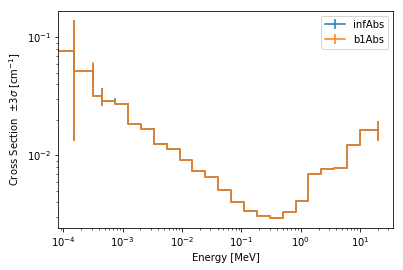

In [31]:
univ3101.plot(['infAbs', 'b1Abs']);

Macroscopic and microscopic quantities, such as micro-group flux, can be plotted on the same figure.
**Note** The units and presentation of the micro- and macro-group fluxes are dissimilar, and the units do not agree with that of the assumed group constants. This will adjust the default y-label, as demonstrated below.

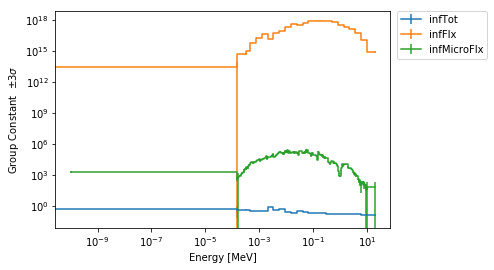

In [32]:
univ3101.plot(['infTot', 'infFlx', 'infMicroFlx'], legend='right');

For plotting data from multiple universes, passed the returned [`matplotlib.axes.Axes`](https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes) object, on which the plot was drawn, into the plot method for the next universe. The `labelFmt` argument can be used to differentiate between plotted data. The following strings are replaced when creating the labels:

|String|Replaced value|
|-|-|
|`{k}`|Name of variable plotted|
|`{u}`| Name of this universe|
|`{b}`| Value of burnup in MWd/kgU|
|`{d}`| Value of burnup in days|
|`{i}`| Burnup index

These can be used in conjunction with the [`matplotlib` $\LaTeX$ rendering](https://matplotlib.org/users/usetex.html) system.

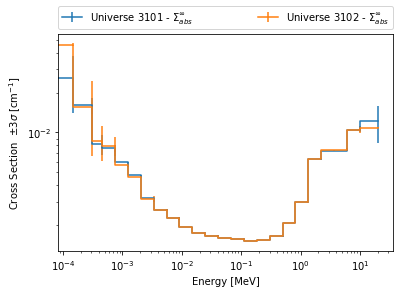

In [33]:
fmt = r"Universe {u} - $\Sigma_{abs}^\infty$"
ax = univ3101.plot('infFiss', labelFmt=fmt)
univ3102.plot('infFiss', ax=ax, labelFmt=fmt, legend='above', ncol=2);

##  User Defined Settings

The user is able to filter the required information by using the settings option.

A detailed description on how to use the settings can be found on:
http://serpent-tools.readthedocs.io/en/latest/settingsTop.html

In [34]:
# Setting are all defined in 'rc'
from serpentTools.settings import rc

In [35]:
# Obtain the user defined keys
rc.keys()

dict_keys(['branching.areUncsPresent', 'branching.intVariables', 'branching.floatVariables', 'depletion.metadataKeys', 'depletion.materialVariables', 'depletion.materials', 'depletion.processTotal', 'detector.names', 'verbosity', 'sampler.allExist', 'sampler.freeAll', 'sampler.raiseErrors', 'sampler.skipPrecheck', 'serpentVersion', 'xs.getInfXS', 'xs.getB1XS', 'xs.reshapeScatter', 'xs.variableGroups', 'xs.variableExtras', 'microxs.getFlx', 'microxs.getXS', 'microxs.getFY'])

The user can modify the settings and only then use the `ResultsReader`

In [36]:
# Change the serpent version to 2.1.30
versionOriginal = rc['serpentVersion']
print('The version defined by default is {}'.format(versionOriginal)) # print the original version
rc['serpentVersion'] = '2.1.30'
print('The version set by the user is {}'.format(rc['serpentVersion'] )) # print the modified version

The version defined by default is 2.1.30
The version set by the user is 2.1.30


In [37]:
# Explicitly state which groups of variables should be stored
# The variables for these groups are defined according to the .yaml file
rc['xs.variableGroups'] = ['versions', 'xs', 'eig', 'burnup-coeff']

In [38]:
# The user can state which cross-sections to store
rc['xs.getInfXS'] = True # Obtain the infinite xs
rc['xs.getB1XS'] = False # Do not store the leakage corrected xs

In [39]:
# Read the file again with the updated settings
resFilt = serpentTools.read(resFile)

In [40]:
# Print all the stored variables in metadata
resFilt.metadata.keys()

dict_keys(['version', 'compileDate', 'debug', 'title', 'confidentialData', 'inputFileName', 'workingDirectory', 'hostname', 'cpuType', 'cpuMhz', 'startDate', 'completeDate'])

In [41]:
# All the variables can be obtained by using 'resdata.keys()'
resFilt.resdata.keys() # contains all the variable as a dict_keys

dict_keys(['burnMaterials', 'burnMode', 'burnStep', 'burnup', 'burnDays', 'nubar', 'anaKeff', 'impKeff', 'colKeff', 'absKeff', 'absKinf', 'geomAlbedo'])

In [42]:
# obtain the results for universe=0 and index=1 (burnup and timeDays are inserted but not used)
univ0Filt = resFilt.getUniv('0', burnup=0.0, index=1, timeDays=0.0)  

In [43]:
# Obtain all the variables stored in 'infExp' field
univ0Filt.infExp.keys() 

dict_keys(['infCapt', 'infAbs', 'infFiss', 'infNsf', 'infNubar', 'infKappa', 'infInvv', 'infScatt0', 'infScatt1', 'infScatt2', 'infScatt3', 'infScatt4', 'infScatt5', 'infScatt6', 'infScatt7', 'infTranspxs', 'infDiffcoef', 'infRabsxs', 'infRemxs', 'infChit', 'infChip', 'infChid', 'infS0', 'infS1', 'infS2', 'infS3', 'infS4', 'infS5', 'infS6', 'infS7'])

In [44]:
# Obtain all the variables stored in 'gc' field
univ0Filt.gc.keys() 

dict_keys([])